In [1]:
import tensorflow as tf
import keras
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import utils
import scoring
import numpy as np

from skopt import Optimizer

from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import Matern, RBF, WhiteKernel

from skopt.learning import RandomForestRegressor

from skopt.acquisition import gaussian_ei as acq_func

from IPython import display

Using TensorFlow backend.


In [2]:
### Importing and structuring data ###

DATA_PATH = "./data/"
train, test = utils.load_small_data_csv(DATA_PATH,"train_smaller100.csv.gz" , "test_smaller100.csv.gz", utils.SIMPLE_FEATURE_COLUMNS)

PointResiduals,Angles = utils.kink(train)
train['PointResiduals'] = pd.Series(PointResiduals, index=train.index)
train['Angles'] = pd.Series(PointResiduals, index=train.index)


train_part, val_part = train_test_split(train, test_size=0.20, shuffle=True)
x_train = train_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values
x_val   =  val_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values
y_train = train_part.loc[:, ["label"]].values
y_val = val_part.loc[:, ["label"]].values
#y_train_weight = train_part.loc[:, ["weight"]].values

# turn labels into categorical classes
classes = [0,1]
y_train = keras.utils.to_categorical(y_train, num_classes=len(classes))
y_val   = keras.utils.to_categorical(y_val,   num_classes=len(classes))

In [3]:
### Defining utils ###

# Rectified linear unit

def relu(x):
  return np.array([ (i>0) * abs(i) for i in x ])

# plotting the bayesian optimizer

def plot_bo(bo, suggestion=None, value=None):
    a, b = bo.space.bounds[0]
    
    # getting the latest model
    model = bo.models[-1]
    
    xs = np.linspace(a, b, num=100)
    x_model = bo.space.transform(xs.reshape(-1, 1).tolist())
    
    mean, std = model.predict(x_model, return_std=True)
    
    plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.scatter(
        np.array(bo.Xi)[:, 0],
        np.array(bo.yi),
        color='red',
        label='observations'
    )
    if suggestion is not None:
        plt.scatter([suggestion], value, color='blue', label='suggestion')
    
    plt.plot(xs, mean, color='green', label='model')
    plt.fill_between(xs, mean - 1.96 * std, mean + 1.96 * std, alpha=0.1, color='green')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    acq = acq_func(x_model, model, np.min(bo.yi))
    plt.plot(xs, acq, label='Expected Improvement')
    plt.legend()
    
    plt.show()

# 

def cum_min(xs):
    result = np.zeros_like(xs)
    cmin = xs[0]
    
    result[0] = xs[0]
    
    for i in range(1, xs.shape[0]):
        if cmin > xs[i]:
            cmin = xs[i]

        result[i] = cmin
    
    return result

# plots progress of BO over time

def plot_convergence(bo):
    display.clear_output(wait=True)
    values = np.array(bo.yi)
    
    plt.figure(figsize=(12, 6))
    plt.plot(cum_min(values), label='minimal discovered')
    plt.scatter(np.arange(len(bo.yi)), bo.yi, label='observations')
    plt.xlabel('step', fontsize=14)
    plt.ylabel('loss', fontsize=14)
    
    plt.legend(loc='upper right', fontsize=18)
    
    plt.show()

# Prints best parameters
    
def print_best(bo):
    best_result_index = np.argmin(bo.yi)
    best_parameters = bo.Xi[best_result_index]

    NodesInFirstDense, NodesInSecondDense, DropoutValue, INIT_LEARNINGRATE = best_parameters
    
    print(
        'Best model:\n Nodes in first dense layer= {0} \n Nodes in second dense layer= {1} \n learning rate= {2} \n Dropout value= {3}'.format(
            int(np.ceil(NodesInFirstDense)),
            int(np.ceil(NodesInSecondDense)),
            INIT_LEARNINGRATE,
            DropoutValue
        )
    )

In [4]:
### Target function with as input optimizeable parameters ###

def target_function(params, X_train=x_train, y_train=y_train, X_score=x_val, y_score=y_val):
    
    # Optimized parameters
    NodesInFirstDense, NodesInSecondDense, DropoutValue, INIT_LEARNINGRATE = params
    
    # Making sure that the number of nodes are integers
    NodesInFirstDense = int(np.ceil(NodesInFirstDense))
    NodesInSecondDense = int(np.ceil(NodesInSecondDense))
    
    # Two parameters not optimized in this case, but can be optimized if needed
    BATCH_SIZE = 16  # should be a factor of len(x_train) and len(x_val) etc.
    EPOCHS = 3

    assert len(y_train) == len(x_train), "x_train and y_train not same length!"
    #assert len(y_train) % BATCH_SIZE == 0, "batch size should be multiple of training size,{0}/{1}".format(len(y_train),BATCH_SIZE)

    from keras.models import Sequential
    from keras.layers import Dense, Activation, Dropout
    from keras.layers.normalization import BatchNormalization

    K.clear_session()

    model = Sequential()
    model.add(Dense(NodesInFirstDense, activation='relu', input_shape=( len( utils.SIMPLE_FEATURE_COLUMNS ), ))) #length = input vars
    model.add(BatchNormalization())
    model.add(Dropout(DropoutValue))
    model.add(Dense(NodesInSecondDense , activation='relu'))
    model.add(Dense( len(classes) )) # muon and 'other'
    model.add(Activation("softmax")) # output probabilities

    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.adamax(lr=INIT_LEARNINGRATE),
        metrics=['accuracy'] 
        )


    model.fit(
        x_train, y_train,
        batch_size = BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = (x_val, y_val),
        shuffle = True
        )

    #model.save_model("keras_basic_model.xgb")


    # score

    validation_predictions = model.predict_proba(val_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 1]
    result = scoring.rejection90(val_part.label.values, validation_predictions, sample_weight=val_part.weight.values)
    print(result)
    
    return 1 - result

In [5]:
### Setting dimensions for optimizeable parameters ###

dimensions_4 =[
    # NodesInFirstDense
    (4.0, 300.0),
    
    # NodesInSecondDense
    (4.0, 300.0),
    
    # LOG_INIT_LEARNINGRATE
    (1.0e-4, 1.0e-2),
    
    # DropoutValue
    (0.0, 0.1)
]

In [6]:
### Random forest regressor as optimizer ###

bo_rf_4 = Optimizer(
    dimensions=dimensions_4,
    base_estimator=RandomForestRegressor(
        n_estimators=100, n_jobs=4, min_variance=1.0e-6
    ),
    n_initial_points=5,
    acq_func='EI',   
)

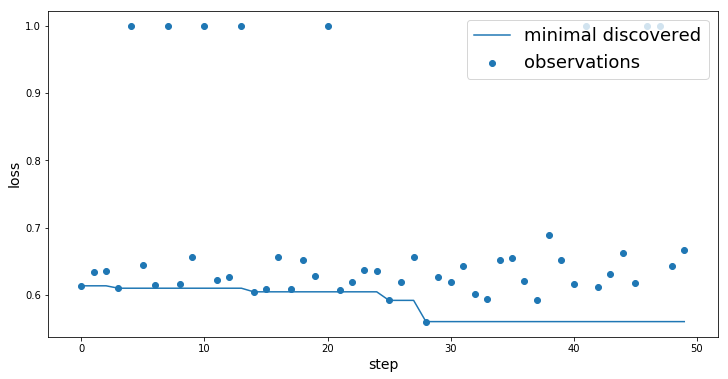

In [7]:
### Actual optimization process ###

Parameter_List = ([])
for i in range(50):
    x = bo_rf_4.ask()
    print(x)
    f = target_function(x) # Other inputs are automatically set
    
    Parameter_List = np.append(Parameter_List, x)
    bo_rf_4.tell(x, f)
        
    plot_convergence(bo_rf_4)

In [8]:
print_best(bo_rf_4)

Best model:
 Nodes in first dense layer= 271 
 Nodes in second dense layer= 280 
 learning rate= 0.02532767329545395 
 Dropout value= 0.0009682674694188368


In [9]:
### Testing the found parameters to see if the results are reproduceable ###

INIT_LEARNINGRATE = 0.02532767329545395  
BATCH_SIZE = 16  # should be a factor of len(x_train) and len(x_val) etc.
EPOCHS = 3

assert len(y_train) == len(x_train), "x_train and y_train not same length!"
#assert len(y_train) % BATCH_SIZE == 0, "batch size should be multiple of training size,{0}/{1}".format(len(y_train),BATCH_SIZE)

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization

K.clear_session()

model = Sequential()
model.add(Dense(271, activation='relu', input_shape=( len( utils.SIMPLE_FEATURE_COLUMNS ), ))) #length = input vars
model.add(BatchNormalization())
model.add(Dropout(0.0009682674694188368))
model.add(Dense(280, activation='relu'))
model.add(Dense( len(classes) )) # muon and 'other'
model.add(Activation("softmax")) # output probabilities

print(model.summary())

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.adamax(lr=INIT_LEARNINGRATE),
    metrics=['accuracy'] 
    )

# Running test for 5 times in this case
for i in range(0,5):
    model.fit(
        x_train, y_train,
        batch_size = BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = (x_val, y_val),
        shuffle = True
        )


    #model.save_model("keras_basic_model.xgb")


    # score

    validation_predictions = model.predict_proba(val_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 1]
    result = scoring.rejection90(val_part.label.values, validation_predictions, sample_weight=val_part.weight.values)
    print(result)
    
    i += 1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 271)               17886     
_________________________________________________________________
batch_normalization_1 (Batch (None, 271)               1084      
_________________________________________________________________
dropout_1 (Dropout)          (None, 271)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 280)               76160     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 562       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 95,692
Trainable params: 95,150
Non-trainable params: 542
_________________________________________________________________
None

In [11]:
#### Original keras model for reference ####

INIT_LEARNINGRATE = 5e-3
BATCH_SIZE = 16  # should be a factor of len(x_train) and len(x_val) etc.
EPOCHS = 3

assert len(y_train) == len(x_train), "x_train and y_train not same length!"
#assert len(y_train) % BATCH_SIZE == 0, "batch size should be multiple of training size,{0}/{1}".format(len(y_train),BATCH_SIZE)

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization

K.clear_session()

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=( len( utils.SIMPLE_FEATURE_COLUMNS ), ))) #length = input vars
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(50 , activation='relu'))
model.add(Dense( len(classes) )) # muon and 'other'
model.add(Activation("softmax")) # output probabilities

print(model.summary())

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.adamax(lr=INIT_LEARNINGRATE),
    metrics=['accuracy'] 
    )


model.fit(
    x_train, y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_val, y_val),
    shuffle = True
    )

#model.save_model("keras_basic_model.xgb")


# score

validation_predictions = model.predict_proba(val_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 1]
result = scoring.rejection90(val_part.label.values, validation_predictions, sample_weight=val_part.weight.values)
print(result)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               6600      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 12,152
Trainable params: 11,952
Non-trainable params: 200
_________________________________________________________________
None

In [ ]:
for i in range(0,5):
    
    for i in range(0,5):
        
        
        

In [19]:
best_result_index = np.argmin(bo_rf_4.yi)
best_parameters = bo_rf_4.Xi[best_result_index]

bo_rf_4.yi

[0.6138837783026205,
 0.6349518151422029,
 0.6360014049368095,
 0.6103059598267513,
 1.0,
 0.6449686461789483,
 0.6145585949283894,
 1.0,
 0.6172820058660087,
 0.6566584275598751,
 1.0,
 0.6220041901481674,
 0.6264386787015994,
 1.0,
 0.604951611087879,
 0.6095909838720766,
 0.656927293426929,
 0.608980667919611,
 0.6527089089759961,
 0.6279269015449258,
 1.0,
 0.6081045806204743,
 0.620127324791726,
 0.6380099990965296,
 0.636469294134699,
 0.5922538027108551,
 0.6199345905937721,
 0.6570863715698672,
 0.56070593629403,
 0.6273099731185394,
 0.6194939710103458,
 0.6431254462198318,
 0.6023394501363204,
 0.5944696087512363,
 0.6524680067610242,
 0.6554186706244411,
 0.620954638858362,
 0.5926848723449285,
 0.6896124602943006,
 0.6521048070287294,
 0.616825635661548,
 1.0,
 0.6113836346199518,
 0.6309258631930211,
 0.6625225050987436,
 0.6186054721300805,
 1.0,
 1.0,
 0.6437468909104095,
 0.6666731793184841]